In [2]:
import pandas as pd
ChessDataDir = "games.csv"
kf = pd.read_csv(ChessDataDir,delimiter=',', header=None, skiprows=1,names=['id','rated','created','last','turns','victory_status'
                                                                            ,'increment','white','white_rating','black'
                                                                            ,'black_rating','moves','openingeco','openingName','openPly'])

In [3]:

f = open("ChessDataset.txt","w")
for index, row in kf.iterrows():
    #print(str(row['Competitiveness']))
    if row['turns'] != "outoftime":
        ChessString = ""
        ChessString += str(row['moves'])+" "
        #ChessString += str(row['turns'])+" "
        f.write(ChessString)
    

In [4]:
#%pip install torch
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 50 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
eval_iters = 100
n_embd = 400
n_head = 7
n_layer = 6
dropout = 0.2


cuda


In [5]:
import os
def save(model,file_name='modelChessBigger.pth'):
    model_folder_path = './model'
    if not os.path.exists(model_folder_path):
        os.makedirs(model_folder_path)
    file_name = os.path.join(model_folder_path, file_name)
    torch.save(model.state_dict(),file_name)
    
def load(file_name='modelChessBigger.pth'):
    model_folder_path = './model'
    
    file_name = os.path.join(model_folder_path, file_name)
    return file_name
    #torch.save(self.state_dict(),file_name)
    


In [6]:
torch.manual_seed(1337)

with open('ChessDataset.txt', 'r', encoding='utf-8', errors='ignore') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text.split(" "))))
Alphabet = chars
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ' '.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text.split(" ")), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


print(len(train_data))

981558


In [7]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y

@torch.no_grad()
#loss estimation
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    #Self attention head

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    #Multiple heads of attention in parallel

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    #Feed Forward Layer

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    
    #Transformer block

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx




In [8]:
model = GPTLanguageModel()
device = 'cuda'
model.load_state_dict(torch.load('./model/modelChessBigger.pth'))
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#print(list(model.signature.keys()))

15.012316 M parameters


In [9]:
print(device)

cuda


In [7]:
for iter in range(max_iters):
   
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        save(model)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 8.4406, val loss 8.4407
step 50: train loss 6.3250, val loss 6.3576
step 100: train loss 5.9775, val loss 5.9869
step 150: train loss 5.6854, val loss 5.6995
step 200: train loss 5.4428, val loss 5.4571
step 250: train loss 5.1799, val loss 5.1984
step 300: train loss 4.9788, val loss 4.9970
step 350: train loss 4.8295, val loss 4.8835
step 400: train loss 4.7444, val loss 4.7839
step 450: train loss 4.6528, val loss 4.7208
step 500: train loss 4.5676, val loss 4.6426
step 550: train loss 4.5068, val loss 4.5765
step 600: train loss 4.4189, val loss 4.5124
step 650: train loss 4.4025, val loss 4.4782
step 700: train loss 4.3360, val loss 4.4312
step 750: train loss 4.3061, val loss 4.3966
step 800: train loss 4.2584, val loss 4.3391
step 850: train loss 4.2147, val loss 4.3163
step 900: train loss 4.1806, val loss 4.2885
step 950: train loss 4.1393, val loss 4.2581
step 1000: train loss 4.1051, val loss 4.2475
step 1050: train loss 4.0662, val loss 4.2150
step 1100: 

KeyboardInterrupt: 

In [10]:
save(model)

In [11]:

# import modules
import pandas as pd
 
# read the data from the csv
device = 'cpu'
alphabet = Alphabet

f = open("ChessDataset.txt", "r", errors="ignore", encoding="utf-8")
inputText = "e4"#f.read()[:block_size]
multiplier = 1
f.close()
chars = sorted(list(set(alphabet)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoiT = { ch:i for i,ch in enumerate(chars) }
itosT = { i:ch for i,ch in enumerate(chars) }
encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
decoder = lambda l: ' '.join([itosT[i] for i in l])
dataT = torch.tensor(encoder(inputText.split(" ")), dtype=torch.long,device='cpu')
dataT = dataT.detach().numpy()

print(list(dataT))
temp = []
for i in range(0,len(list(dataT))):
    temp.append(dataT[i])
print(temp)
dataT = torch.tensor(temp, dtype=torch.long,device='cpu')
print(dataT)
context = dataT.to(device)#torch.tensor(dataInput)

output = (decode(model.cpu().generate(context.reshape(1,len(context)), 1)[0].tolist()))

[4087]
[4087]
tensor([4087])


In [12]:
print(output)

e4 Rde8


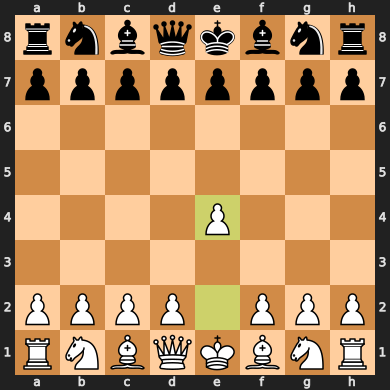

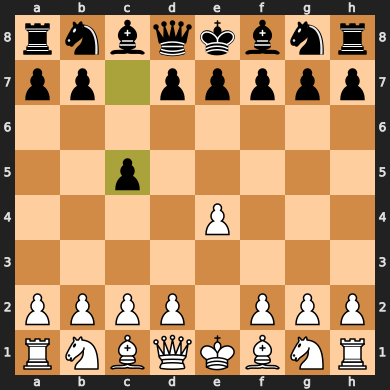

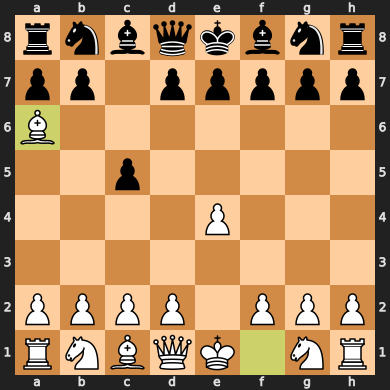

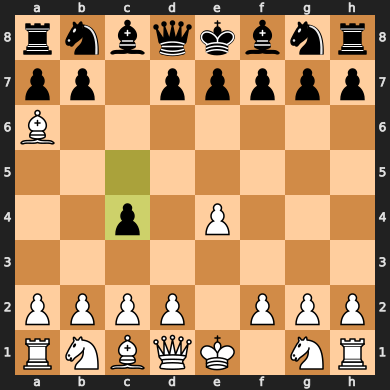

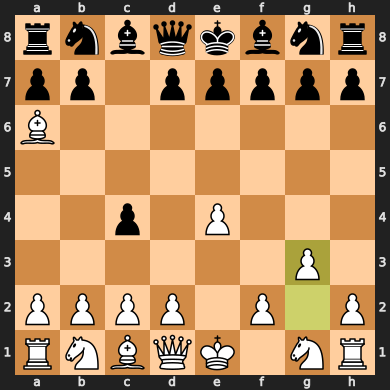

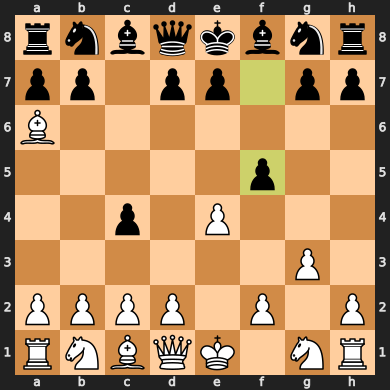

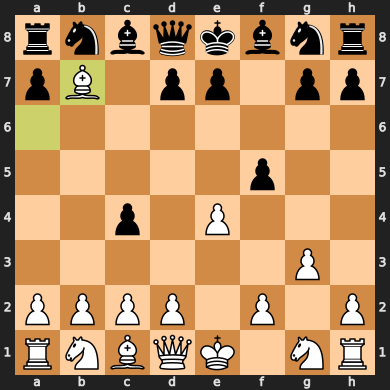

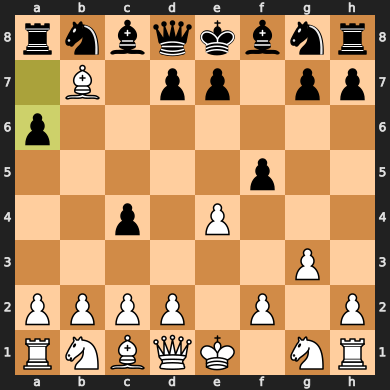

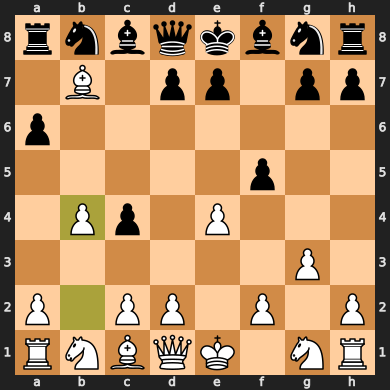

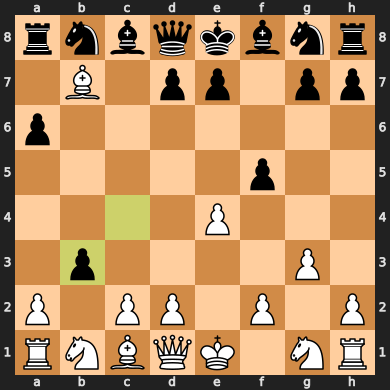

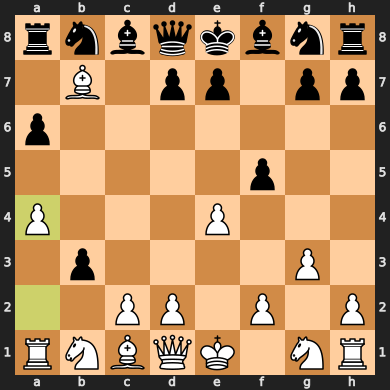

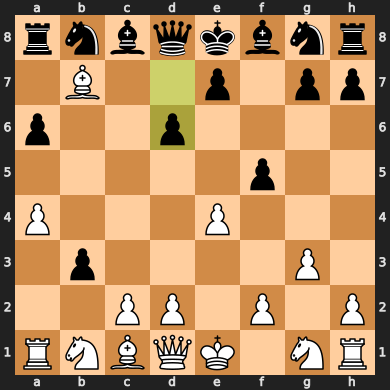

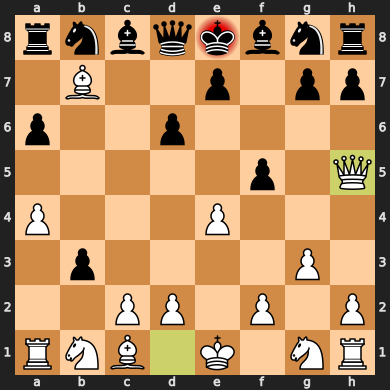

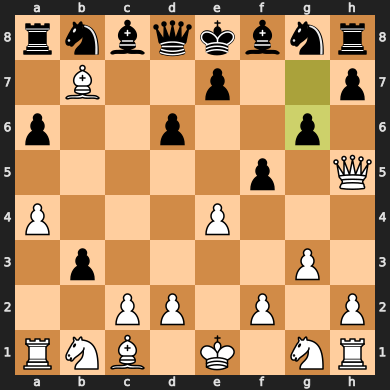

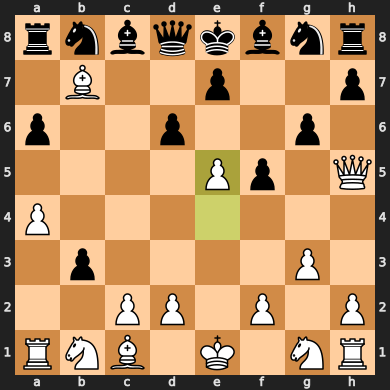

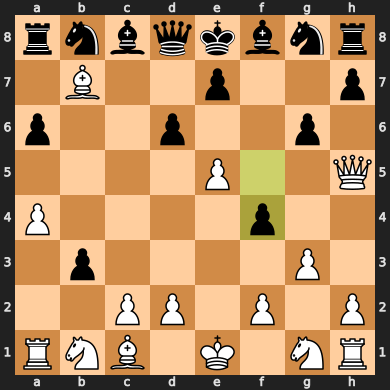

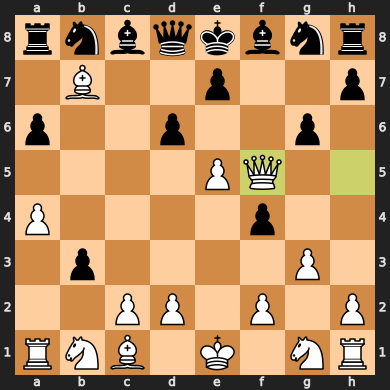

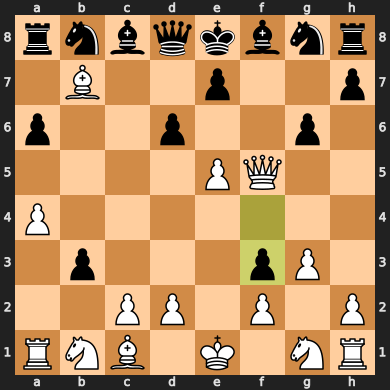

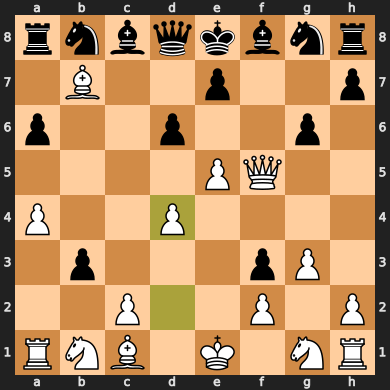

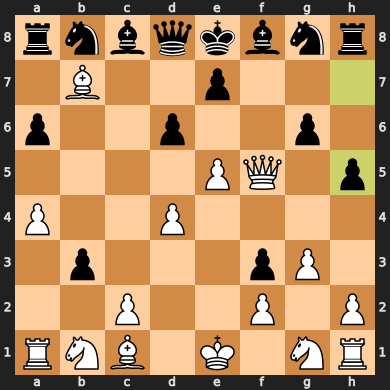

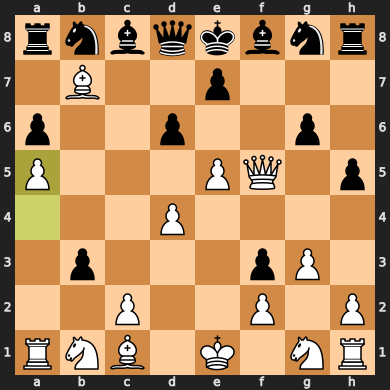

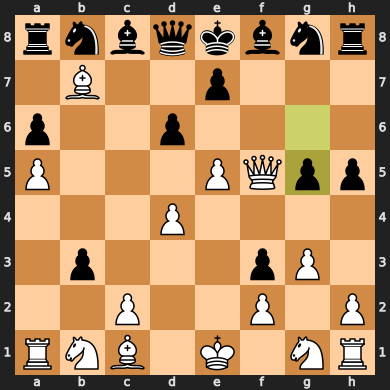

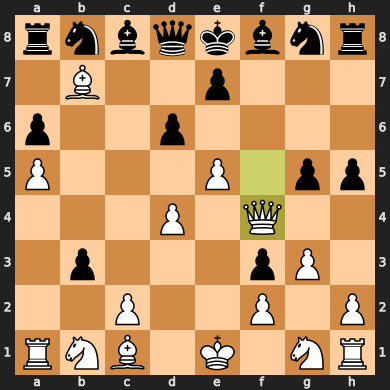

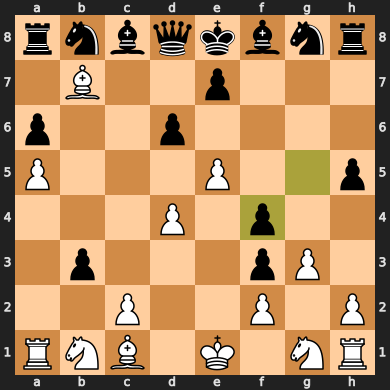

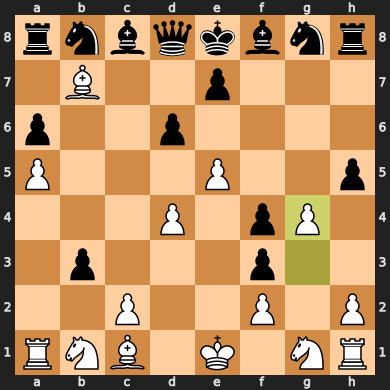

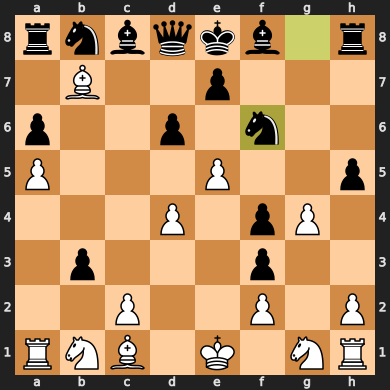

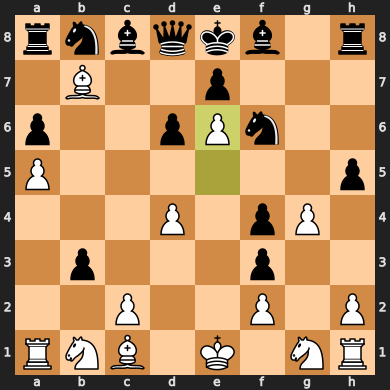

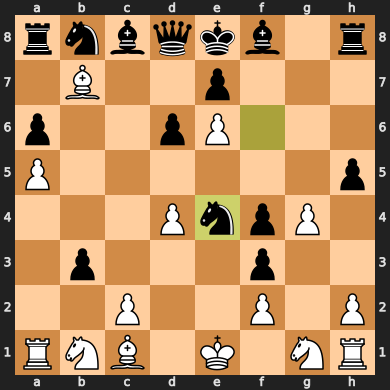

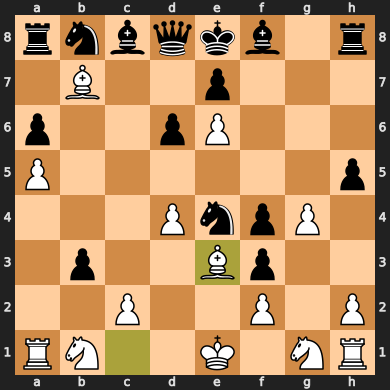

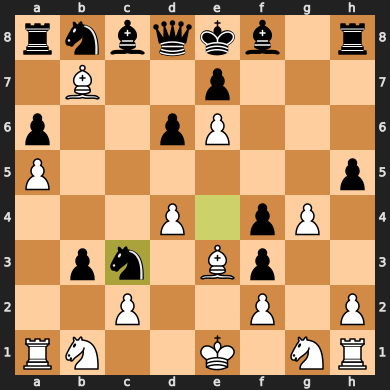

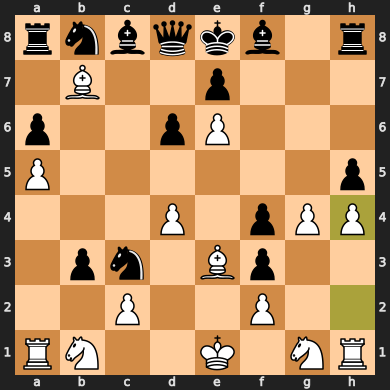

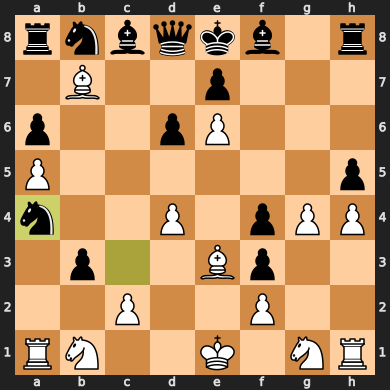

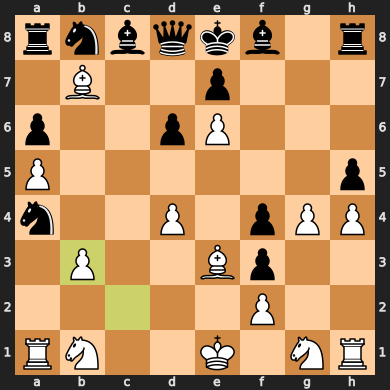

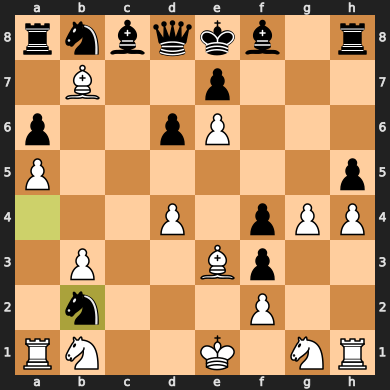

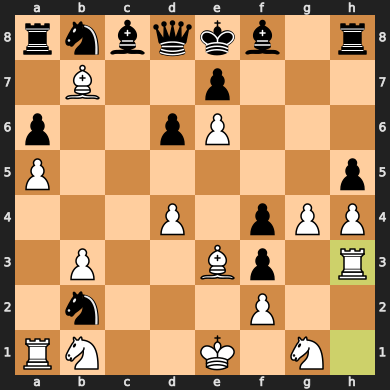

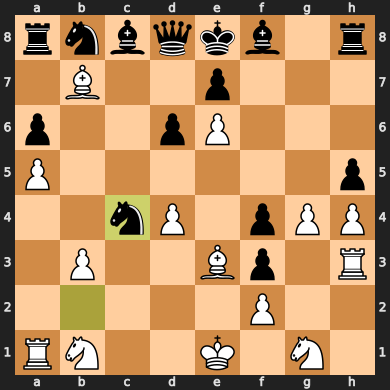

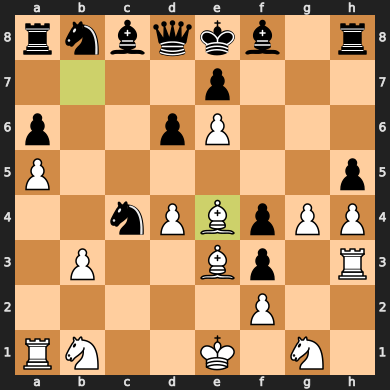

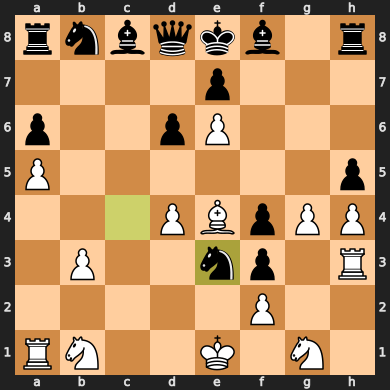

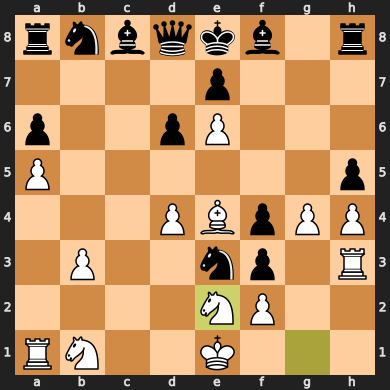

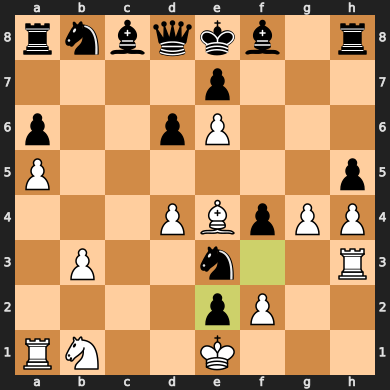

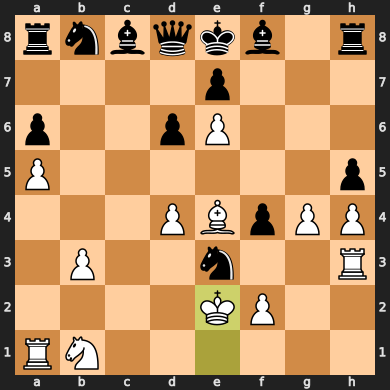

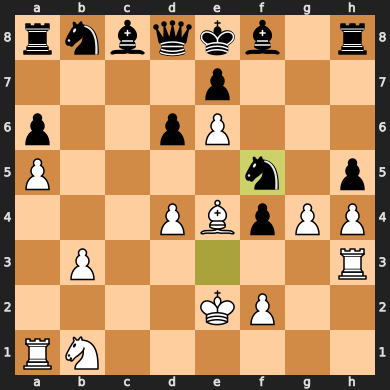

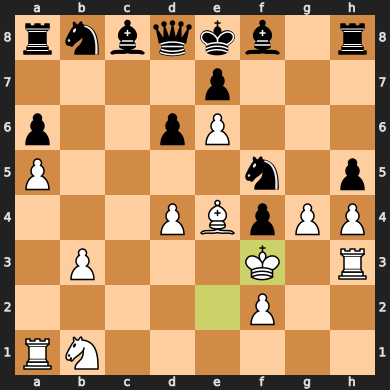

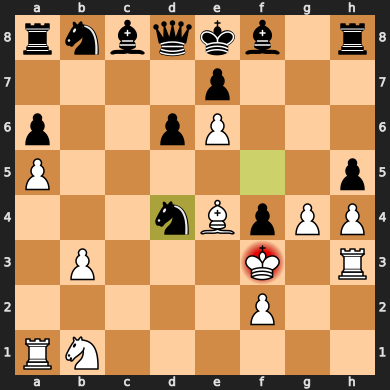

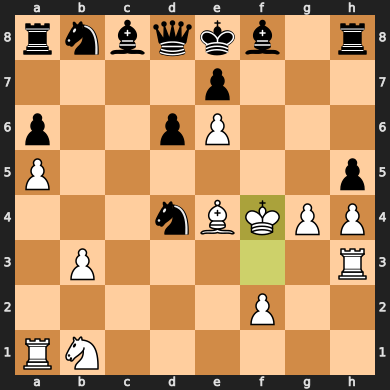

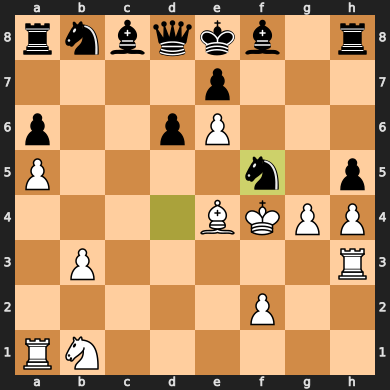

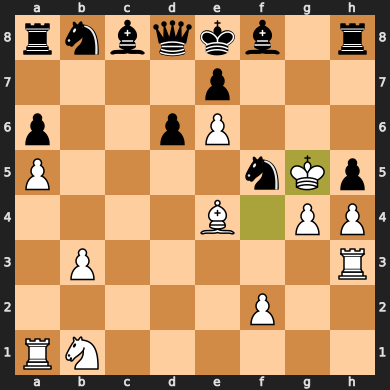

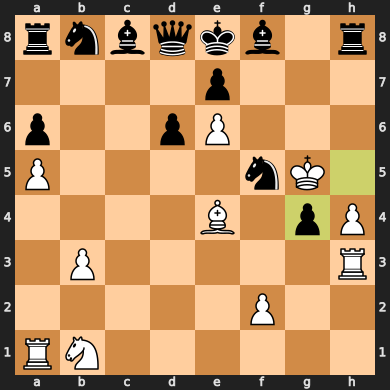

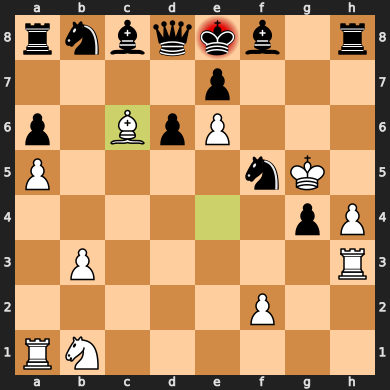

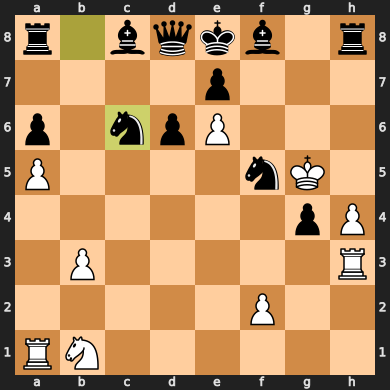

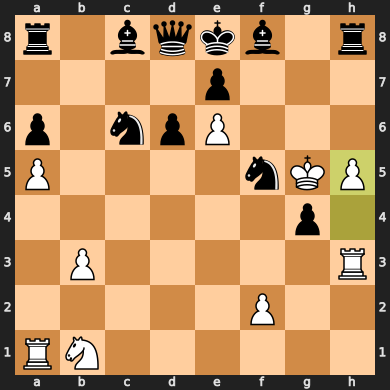

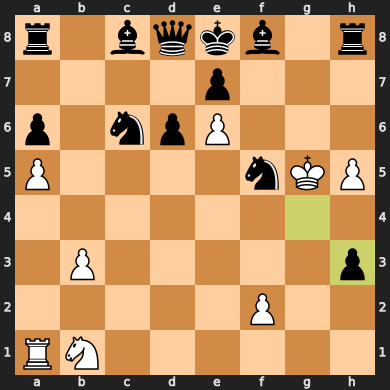

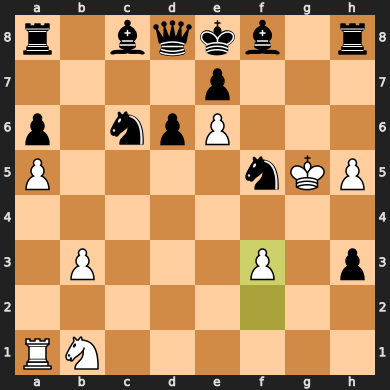

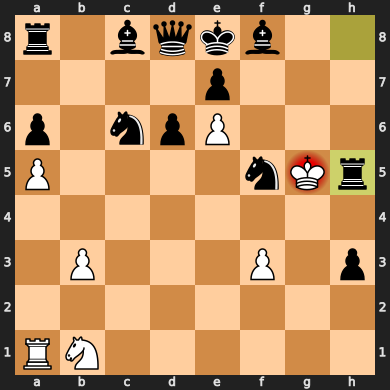

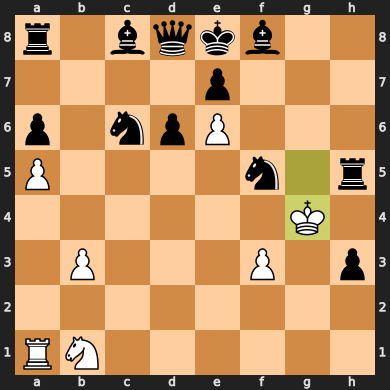

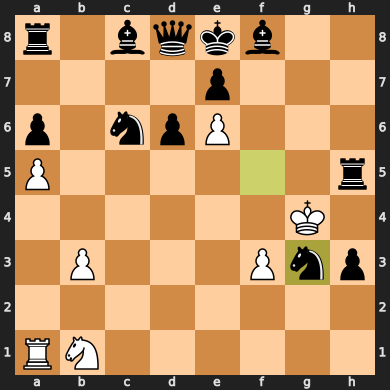

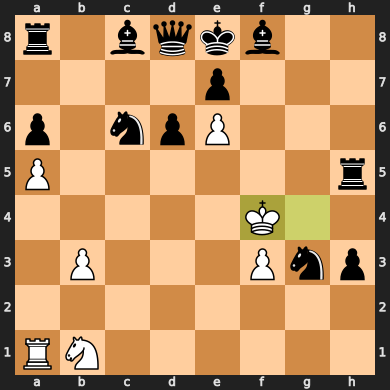

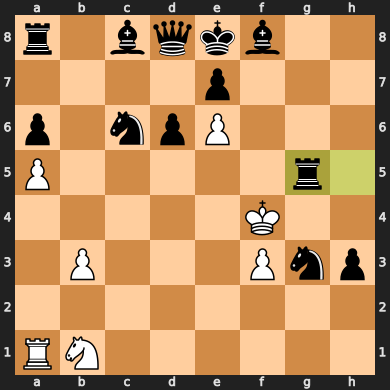

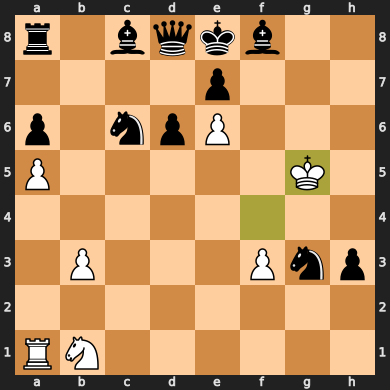

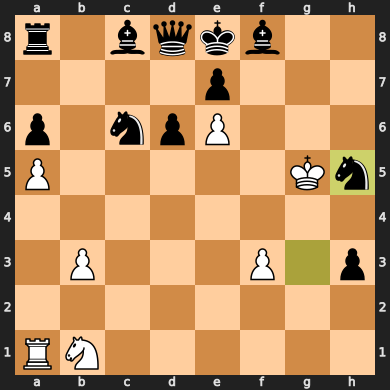

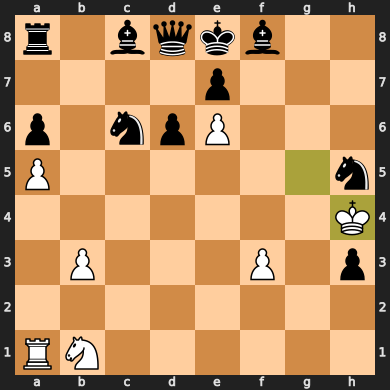

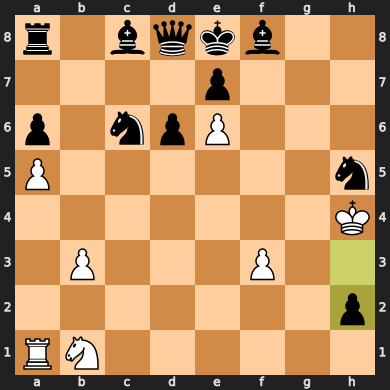

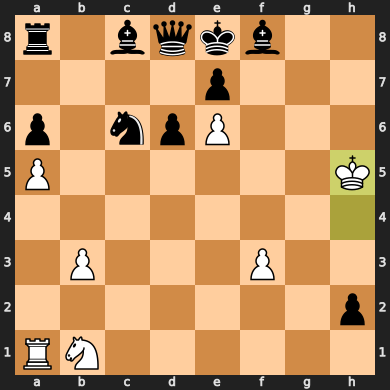

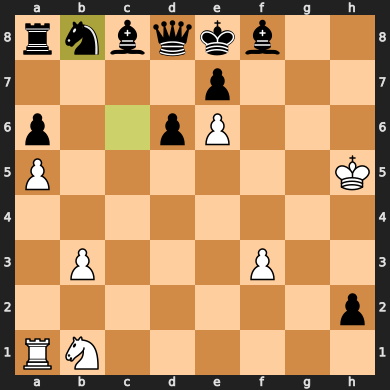

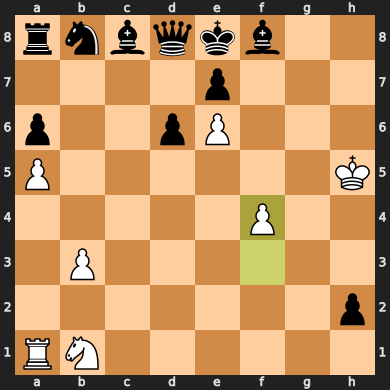

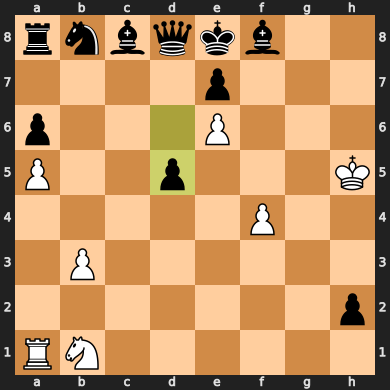

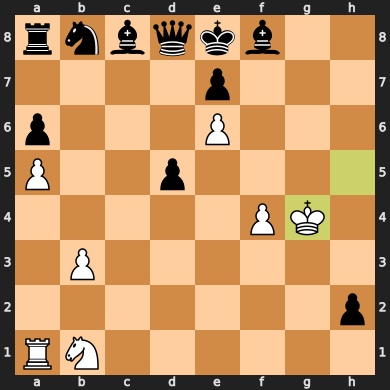

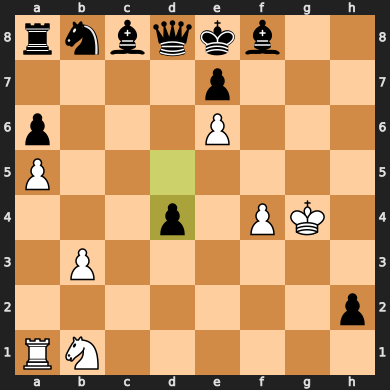

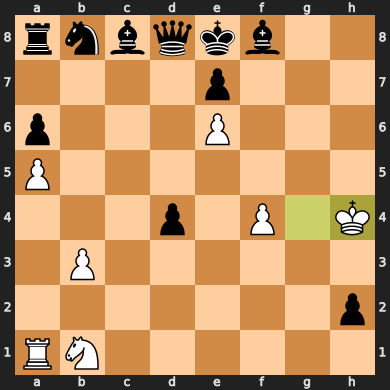

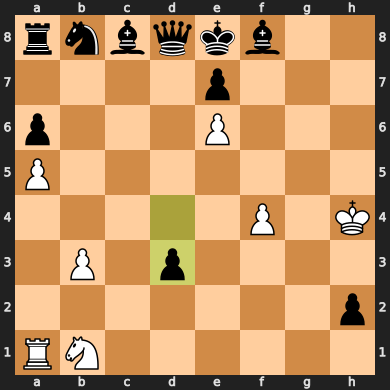

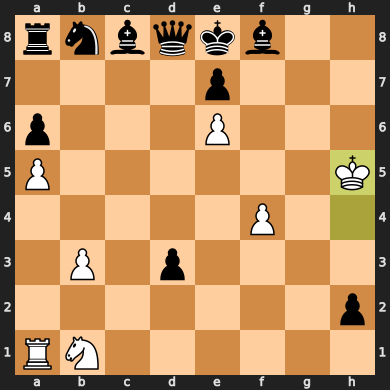

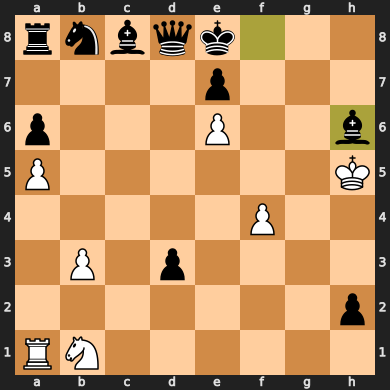

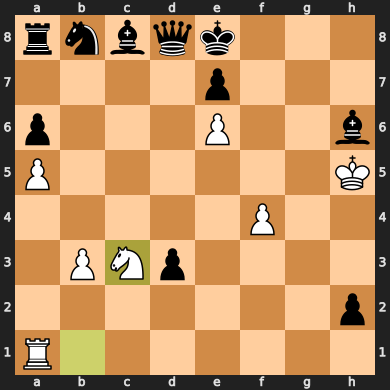

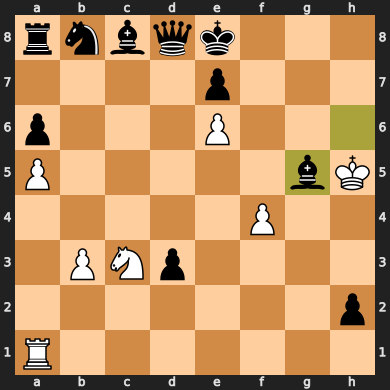

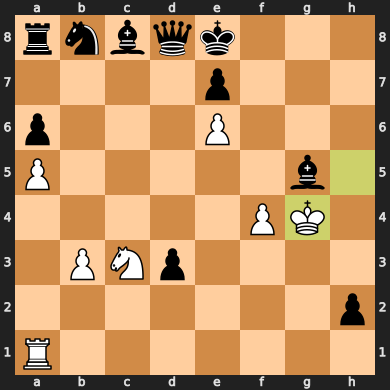

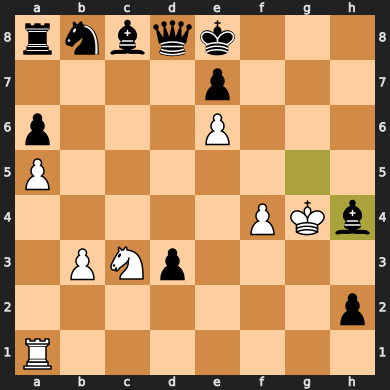

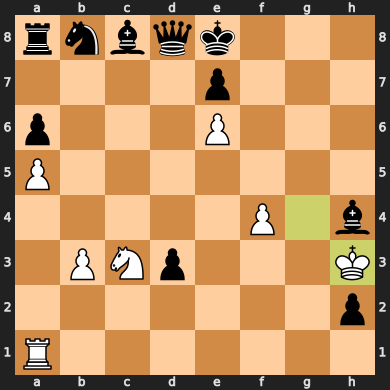

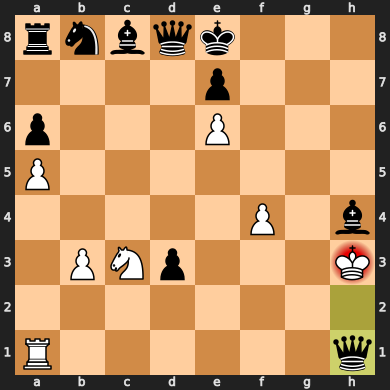

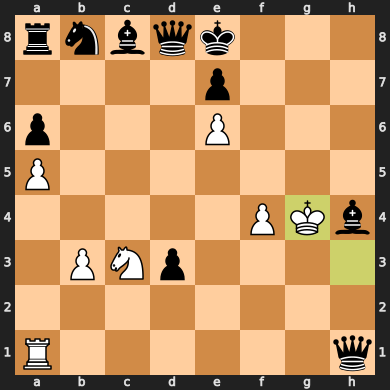

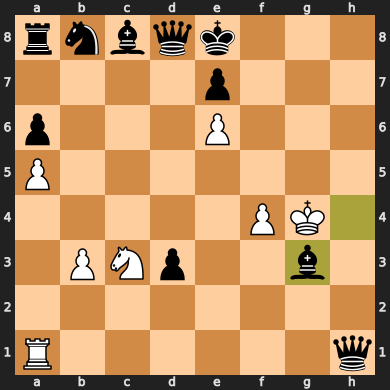

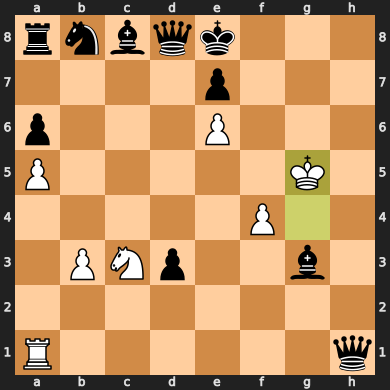

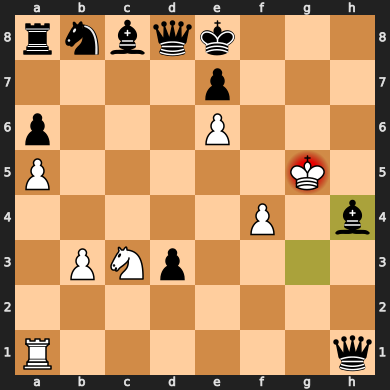

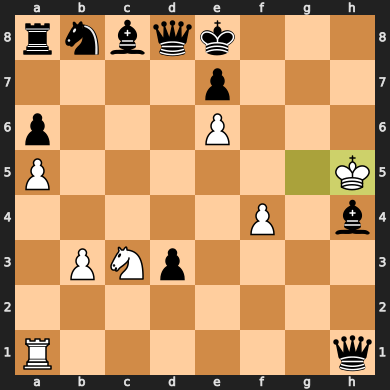

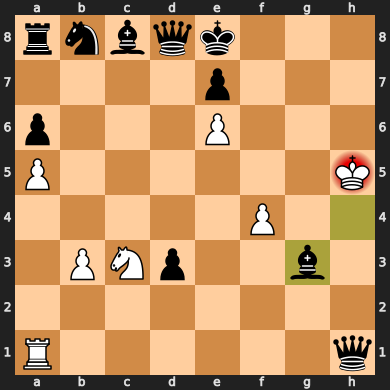

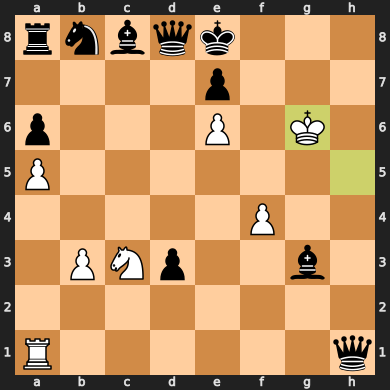

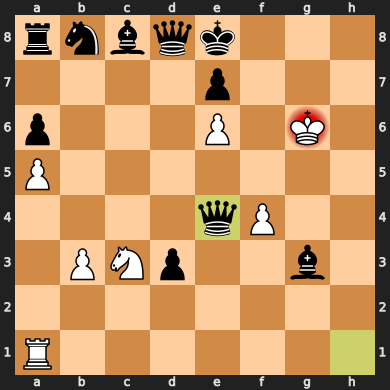

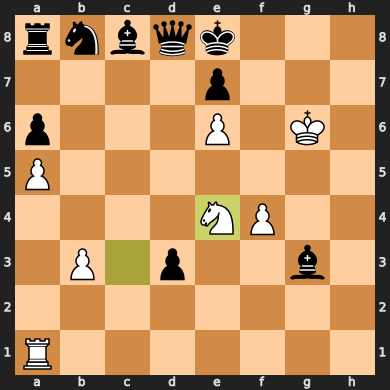

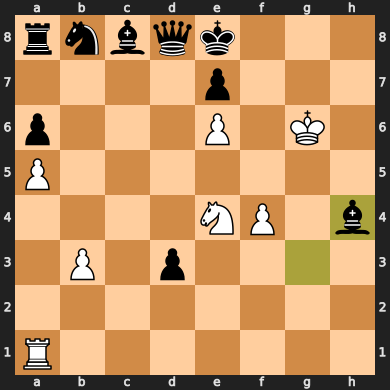

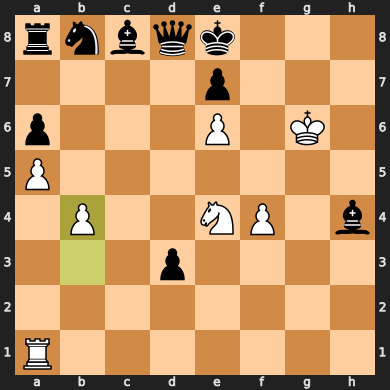

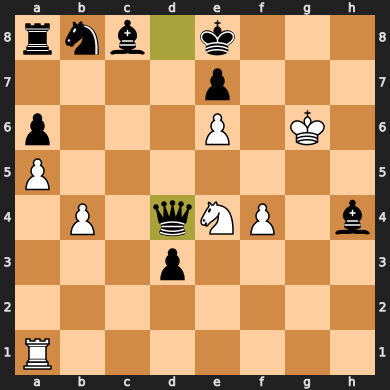

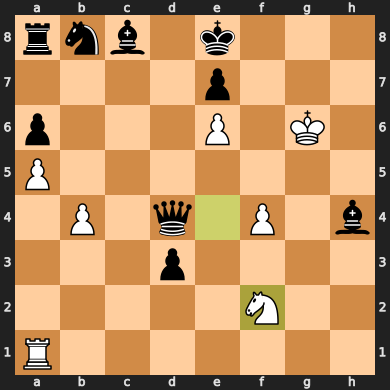

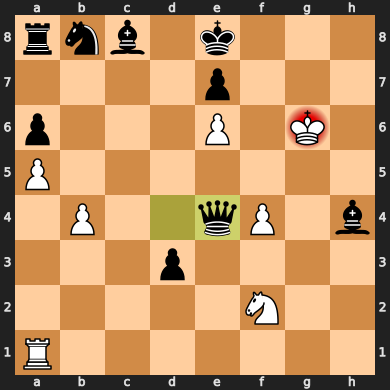

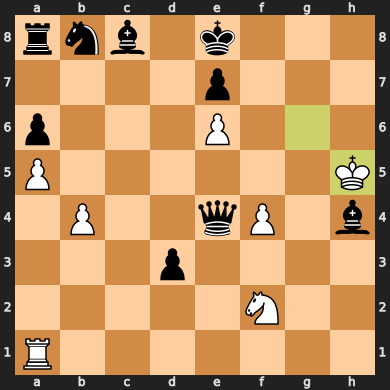

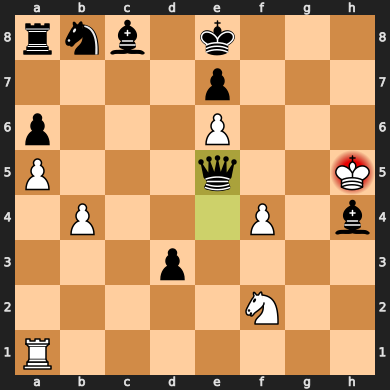

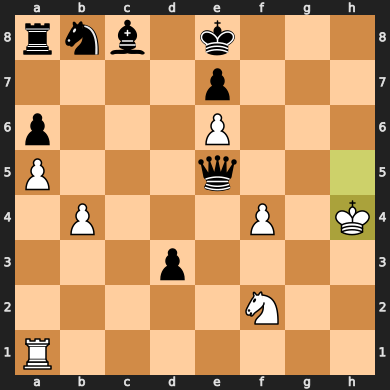

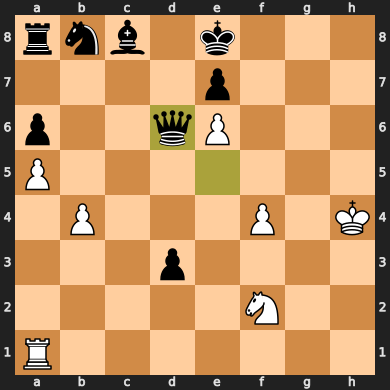

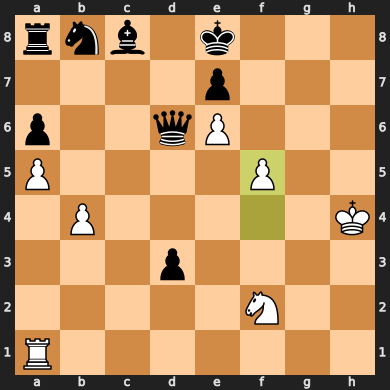

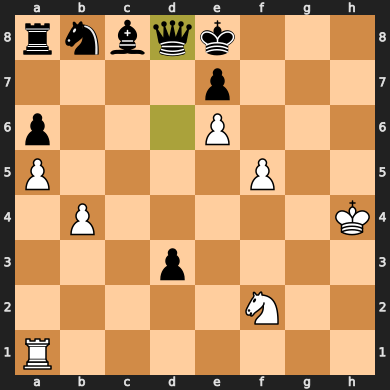

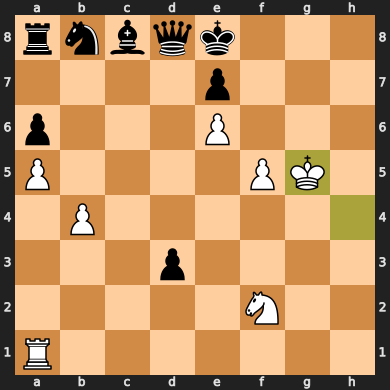

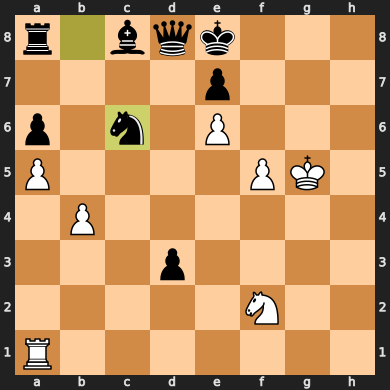

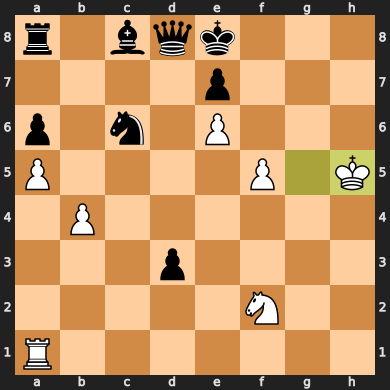

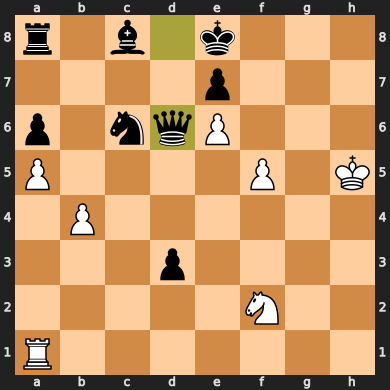

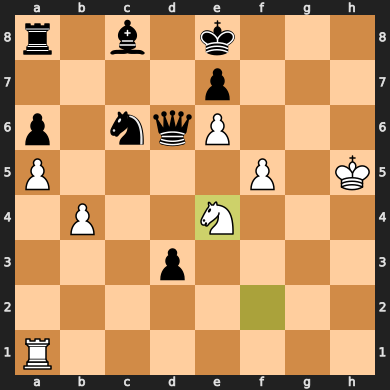

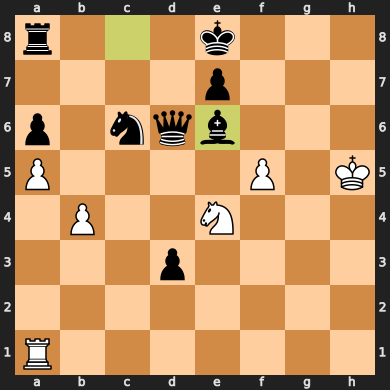

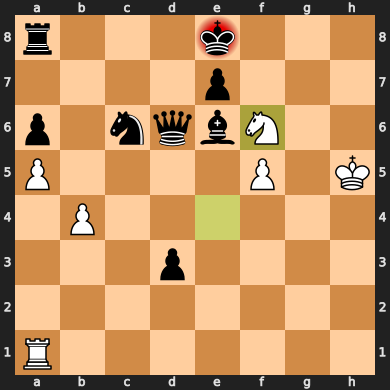

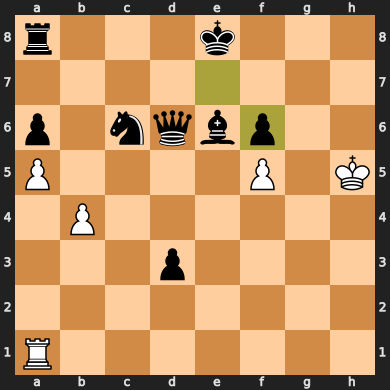

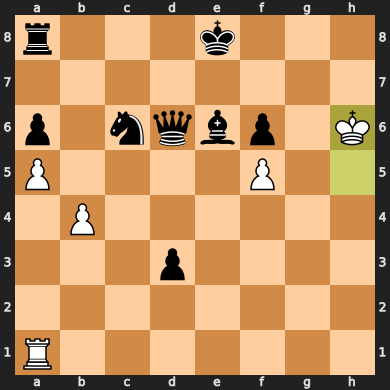

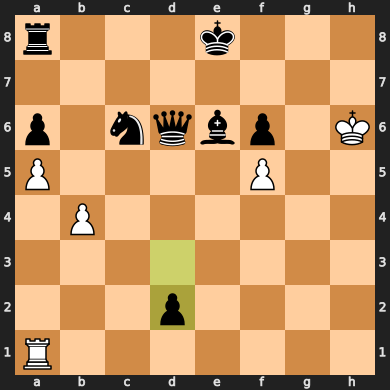

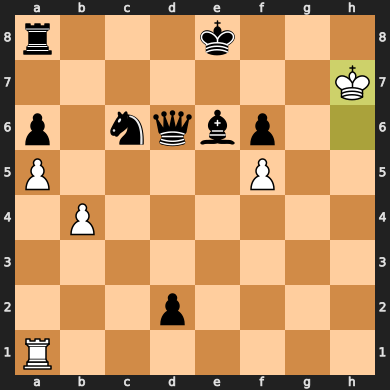

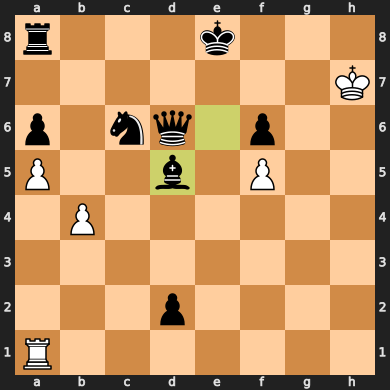

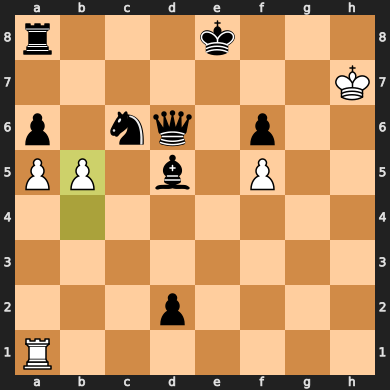

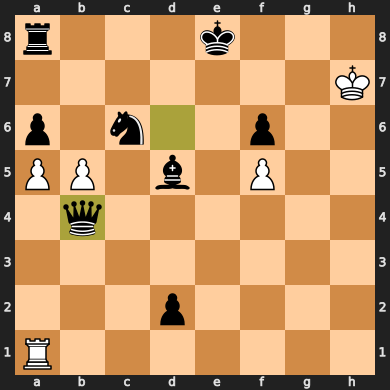

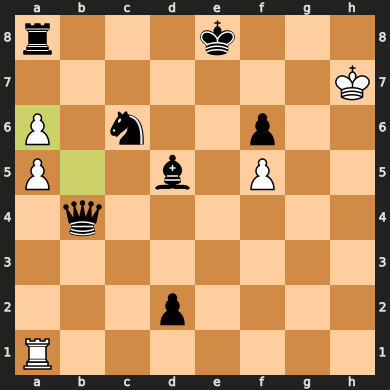

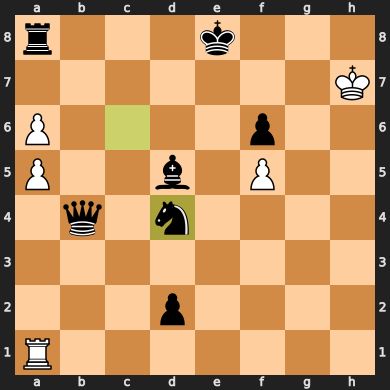

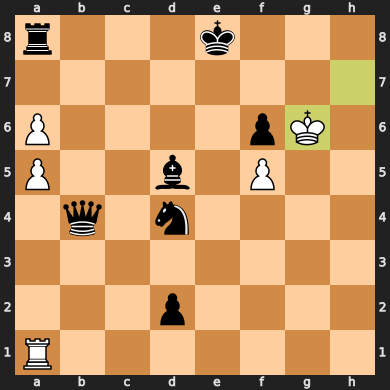

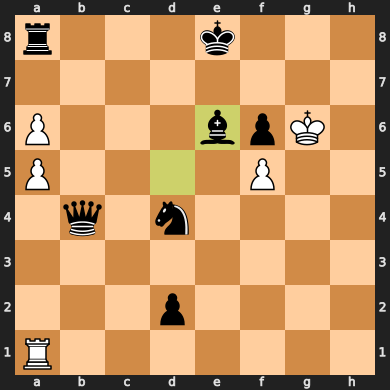

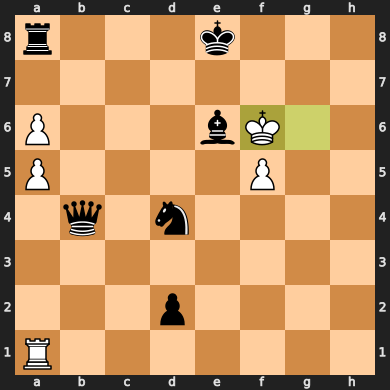

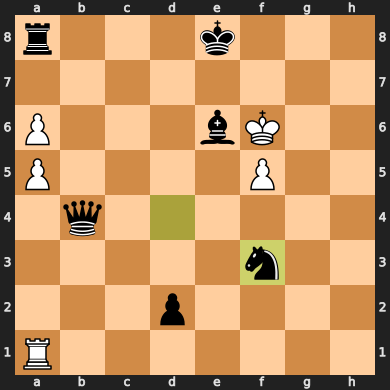

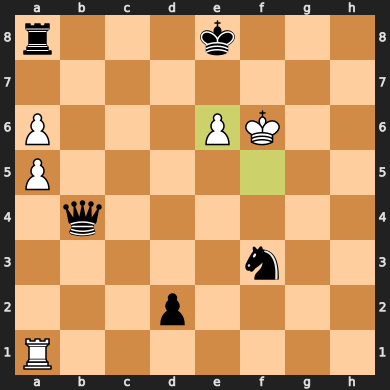

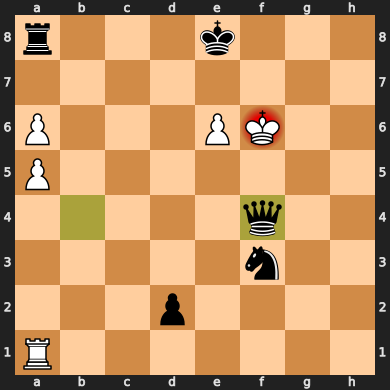

In [20]:
import chess.svg
import chess
currentMoves = ""
board = chess.Board()
for i in range(0,2000):
    
    inputText = currentMoves#f.read()[:block_size]
    dataT = torch.tensor(encoder(inputText.split(" ")), dtype=torch.long,device='cpu')
    dataT = dataT.detach().numpy()

    #print(list(dataT))
    temp = []
    for i in range(0,len(list(dataT))):
        temp.append(dataT[i])
    #print(temp)
    dataT = torch.tensor(temp, dtype=torch.long,device='cpu')
    #print(dataT)
    context = dataT.to(device)#torch.tensor(dataInput)

    output = (decode(model.cpu().generate(context.reshape(1,len(context)), 1)[0].tolist()))
    #print(output)
    
    legal_moves = board.legal_moves
    #print(legal_moves)
    for i in legal_moves:
        if (output.split(" ")[-1] in str(i)):
            move = chess.Move.from_uci(str(i))
            board.push(move)
            currentMoves += str(output.split(" ")[-1])+" "
            #print(board)
            display(board)
            break
    if board.is_checkmate():
        print(board.is_checkmate())
        break



In [17]:
print(board.unicode())

♜ ♞ ♝ ⭘ ⭘ ⭘ ♚ ♜
♟ ⭘ ⭘ ♟ ♞ ⭘ ♟ ♟
⭘ ⭘ ⭘ ⭘ ♟ ♖ ⭘ ⭘
⭘ ♟ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ♙ ⭘ ⭘ ⭘ ♙ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
♙ ♙ ⭘ ⭘ ♙ ♙ ⭘ ⭘
♖ ♘ ♗ ⭘ ♔ ♗ ♘ ⭘


In [21]:
print(board)

r . . . k . . .
. . . . . . . .
P . . . P K . .
P . . . . . . .
. . . . . q . .
. . . . . n . .
. . . p . . . .
R . . . . . . .
